# Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_curve
import xgboost as xgb
from xgboost import XGBClassifier
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier 

# Loading Data

In [2]:
#load data from EDA 
df= pd.read_csv('project2_df.csv')

In [3]:
df.head()

,Unnamed: 0.1,Unnamed: 0,Station,Date,Tmax,Tmin,Tavg,DewPoint,WetBulb,CodeSum,...,year_weather,week,Species_virus,7day_Tavg,10day_Tavg,7day_Precip,10day_Precip,tavg_celsius,wetbulb_celsius,relative_humidity
0,0,0,1,2007-05-29,88,60,74,58,65,BR HZ,...,2007,22,1,74.0,74.0,0.0,0.0,23.333333,18.333333,59.899166
1,1,1,1,2007-05-29,88,60,74,58,65,BR HZ,...,2007,22,1,74.0,74.0,0.0,0.0,23.333333,18.333333,59.899166
2,2,2,1,2007-05-29,88,60,74,58,65,BR HZ,...,2007,22,1,74.0,74.0,0.0,0.0,23.333333,18.333333,59.899166
3,3,3,1,2007-05-29,88,60,74,58,65,BR HZ,...,2007,22,1,74.0,74.0,0.0,0.0,23.333333,18.333333,59.899166
4,4,4,1,2007-05-29,88,60,74,58,65,BR HZ,...,2007,22,1,74.0,74.0,0.0,0.0,23.333333,18.333333,59.899166


# Prepare data for train- test-split

In [4]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Station', 'Date', 'Tmax', 'Tmin', 'Tavg',
       'DewPoint', 'WetBulb', 'CodeSum', 'PrecipTotal', 'StnPressure',
       'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed', 'year_train',
       'month_train', 'day_train', 'Address', 'Species', 'Trap', 'Latitude',
       'Longitude', 'NumMosquitos', 'WnvPresent', 'day_weather',
       'month_weather', 'year_weather', 'week', 'Species_virus', '7day_Tavg',
       '10day_Tavg', '7day_Precip', '10day_Precip', 'tavg_celsius',
       'wetbulb_celsius', 'relative_humidity'],
      dtype='object')

In [5]:
#dropping year, month, day from the train dataset
#dropping address, CodeSum, Trap
#drop date object column, Species with the different types as have 'Species_virus' which is either
#mosquitoes that carry the virus or not. 
df1= df.drop(['Unnamed: 0.1', 'Unnamed: 0', 'CodeSum', 'Address', 'Trap', 'year_train', 'month_train', 'day_train', 'Date', 'Species'], axis=1)

In [6]:
df1.shape

(10506, 28)

In [7]:
#create X, y to be used in the train-test-split arguments
X= df1.drop('WnvPresent', axis=1)
y= df1['WnvPresent']

In [8]:
#creating X, y for undersampling modeling
X_under= X
y_under =y

Resampling from the minority group (WnvPresent =1)

In [9]:
#Resample the minority using SMOTE package
smote = SMOTE()
X, y = smote.fit_resample(X, y)

0    9955
1    9955
Name: WnvPresent, dtype: int64


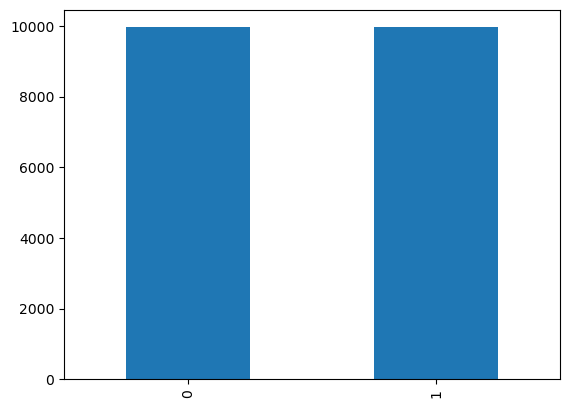

In [10]:
#graphing y value counts to make sure even amount of WnvPresent and not
y.value_counts().plot(kind='bar')
print(y.value_counts())

In [11]:
#split the data to prepare it for modeling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=47)

In [12]:
#check to make sure X, y similar lengths
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(13937, 27) (5973, 27)
(13937,) (5973,)


Now - will try undersampling the data. 

In [13]:
#undersample the zeros in data
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X_under, y_under)

0    551
1    551
Name: WnvPresent, dtype: int64


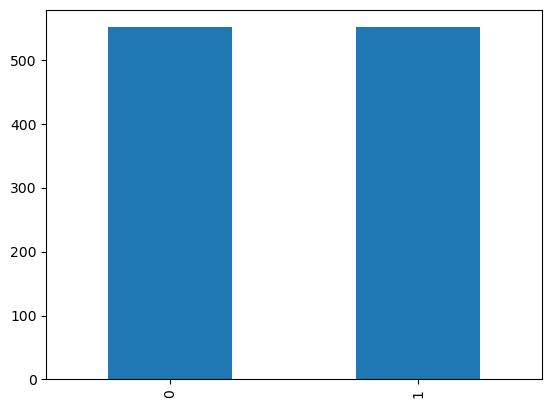

In [14]:
#graphing y value counts to make sure even amount of WnvPresent and not
y_resampled.value_counts().plot(kind='bar')
print(y_resampled.value_counts())

In [15]:
#split the data to prepare it for modeling
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=47)

# Modeling - XGBoost and Random Forest

In [16]:
#creating classification metric measures
def display_confusion_matrix(ytest, ypred, model) :
    cm = confusion_matrix(ytest, ypred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()
def class_report(ytest, ypred) :
    print(classification_report(ytest, ypred))
    
def feature_importance(model) :
    xgb.plot_importance(model)
    plt.rcParams['figure.figsize'] = [6, 4]
    plt.show()

## Model 1 - Base Model for XGBoost for Oversampling Data

In [17]:
#setting the base model for XGBoost for oversampling from SMOTE 
model_1 = xgb.XGBClassifier()
model_1.fit(X_train, y_train)

#use model to predict y values on X_test set
y_pred = model_1.predict(X_test)

Model 1 accuracy score: 0.9568


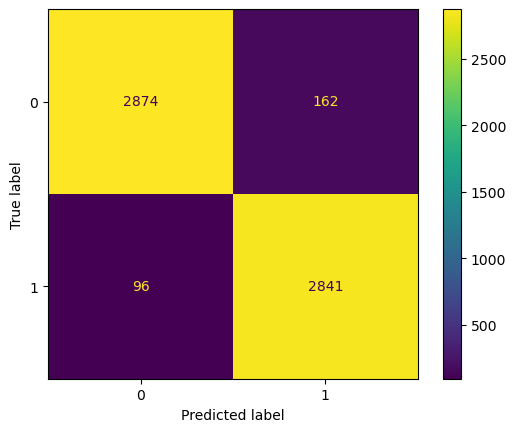

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      3036
           1       0.95      0.97      0.96      2937

    accuracy                           0.96      5973
   macro avg       0.96      0.96      0.96      5973
weighted avg       0.96      0.96      0.96      5973



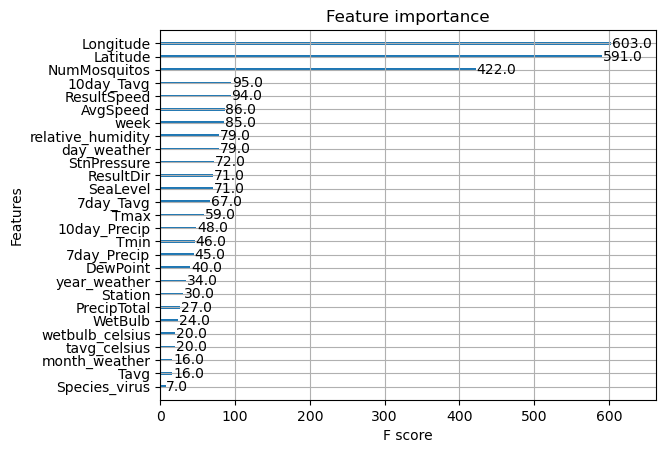

In [18]:
#determine accuracy of model using actual y_test values and predicted y_pred values
print('Model 1 accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

#display confustion matrix for base model of XGBoost
display_confusion_matrix(y_test, y_pred, model_1)

#classification report
class_report(y_test, y_pred)

#feature importance
feature_importance(model_1)

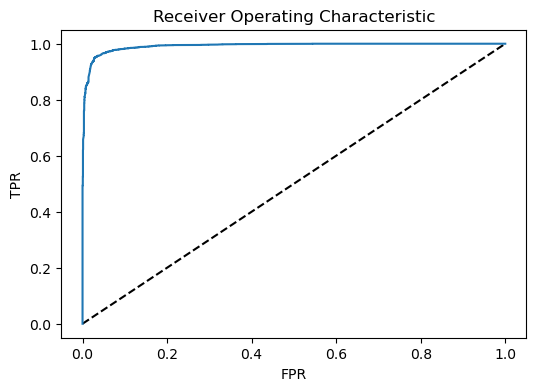

In [19]:
#graph ROC curve
y_pred_prob1 = model_1.predict_proba(X_test)[:,1]
fpr1 , tpr1, thresholds1 = roc_curve(y_test, y_pred_prob1)

plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label= "Model 1")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('Receiver Operating Characteristic')
plt.show()

## Model 2 - Base model for XGBoost for Undersampling Data

In [20]:
#setting the base model for XGBoost for undersampling base model
model_2 = xgb.XGBClassifier()
model_2.fit(X_train_under, y_train_under)

#use model to predict y values on X_test set
y_pred_under = model_2.predict(X_test_under)

Model 2 accuracy score: 0.7976


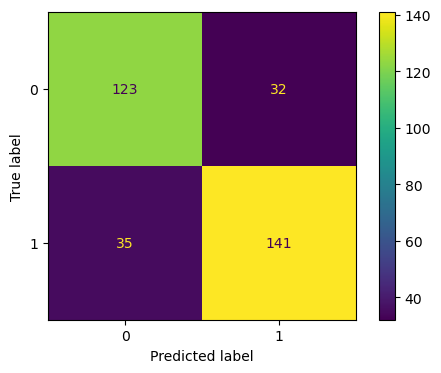

              precision    recall  f1-score   support

           0       0.78      0.79      0.79       155
           1       0.82      0.80      0.81       176

    accuracy                           0.80       331
   macro avg       0.80      0.80      0.80       331
weighted avg       0.80      0.80      0.80       331



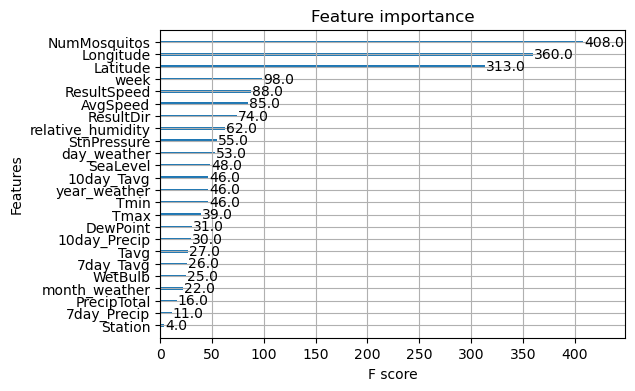

In [21]:
#determine accuracy of model using actual y_test values and predicted y_pred values
print('Model 2 accuracy score: {0:0.4f}'. format(accuracy_score(y_test_under, y_pred_under)))

#display confustion matrix for base model of XGBoost
display_confusion_matrix(y_test_under, y_pred_under, model_2)

#classification report
class_report(y_test_under, y_pred_under)

#feature importance
feature_importance(model_2)

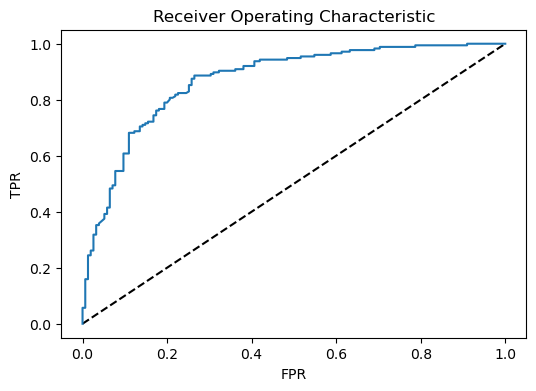

In [23]:
#graph ROC for XGBoost undersampling base model
y_pred_prob1_under = model_2.predict_proba(X_test_under)[:,1]
fpr1 , tpr1, thresholds1 = roc_curve(y_test_under, y_pred_prob1_under)

plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label= "Model 2")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('Receiver Operating Characteristic')
plt.show()

## Model 3 - Changing learning rate on base model for oversampling data 

In [24]:
# using a range of values for learning rate to see how XGBoost model changes for oversampling 
learning_rate_range = np.arange(0.01, 1, 0.05)
train_XG = []
test_XG = [] 

for lr in learning_rate_range:
    xgb_classifier = xgb.XGBClassifier(eta = lr)
    xgb_classifier.fit(X_train, y_train)
    train_XG.append(xgb_classifier.score(X_train, y_train))
    test_XG.append(xgb_classifier.score(X_test, y_test))

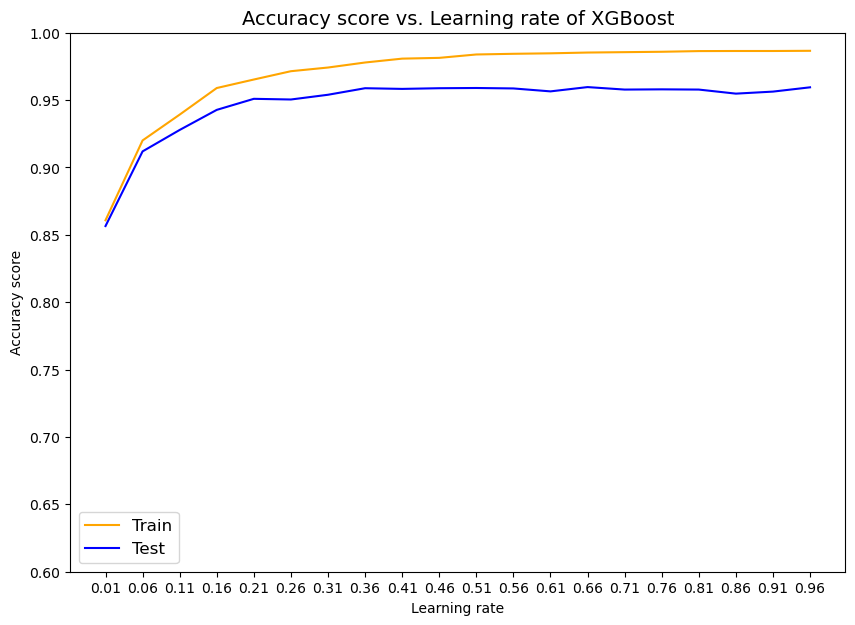

In [25]:
fig = plt.figure(figsize=(10, 7))
plt.plot(learning_rate_range, train_XG, c='orange', label='Train')
plt.plot(learning_rate_range, test_XG, c='blue', label='Test')
plt.xlabel('Learning rate')
plt.xticks(learning_rate_range)
plt.ylabel('Accuracy score')
plt.ylim(0.6, 1)
plt.legend(prop={'size': 12}, loc=3)
plt.title('Accuracy score vs. Learning rate of XGBoost', size=14)
plt.show()

## Model 4- Setting parameters of XGBoost for oversampling data

In [26]:
# set parameters for XGBoost Oversampling 
params = {
            'objective':'binary:logistic',
            'max_depth': 8,
            'learning_rate': .3, #due to graph above
            'n_estimators':200,
            'colsample_bytree': 0.5
        }
                 
# create model with set parameters 
model_4 = XGBClassifier(**params)

# fit the classifier to the training data
model_4.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Model 4 accuracy score: 0.9595


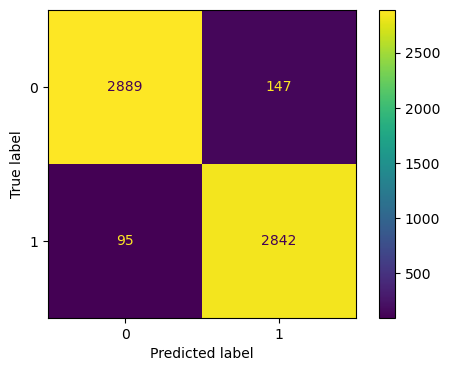

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      3036
           1       0.95      0.97      0.96      2937

    accuracy                           0.96      5973
   macro avg       0.96      0.96      0.96      5973
weighted avg       0.96      0.96      0.96      5973



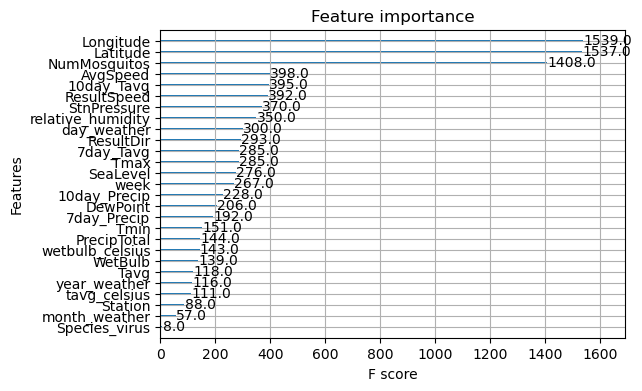

In [27]:
#predict y values from X_test set
y_pred = model_4.predict(X_test)

#determine accuracy of model using actual y_test values and predicted y_pred values
print('Model 4 accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

#display confustion matrix for base model of XGBoost
display_confusion_matrix(y_test, y_pred, model_4)

#classification report
class_report(y_test, y_pred)

#feature importance
feature_importance(model_4)

See how location and number of mosquitoes seem to be a big predictor of this model.

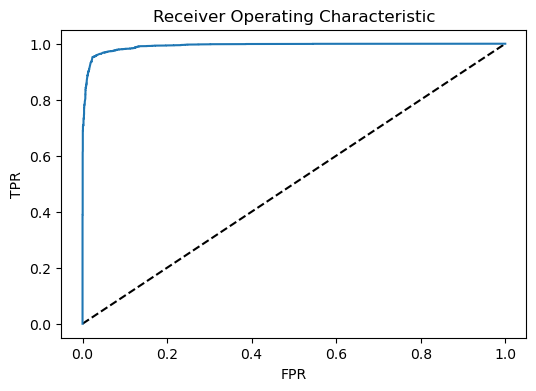

In [28]:
#graph ROC curve
y_pred_prob1 = model_4.predict_proba(X_test)[:,1]
fpr1 , tpr1, thresholds1 = roc_curve(y_test, y_pred_prob1)

plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label= "Model 4")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('Receiver Operating Characteristic')
plt.show()

## Model 5 -Grid Search for XGBoost for Oversampling Data

In [29]:
#set estimator
estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)

In [30]:
#set parameters 
parameters = {
    'max_depth': range (2, 10, 2),
    'n_estimators': range(120, 220, 40),
    'learning_rate': [0.2, 0.4, 0.6],  
    'min_child_weight' : range(2, 7, 1),
    'colsample_bytree': [0.2, 0.5]
}


In [31]:
#grid search with the different parameters listed above 5 cross validations
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 5,
    verbose=True
)

In [32]:
#fit the grid search on the X_train and y_train data of the Undersampling data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None, ...),
             n_jobs=10,
             param_grid={'colsample_bytree': [0.2, 0.5],
                         'learning_rate': [0.2, 0.4, 0.6],
                         'max_depth': range(2, 10, 2),
                         'min_child_weight': range(2, 7),
                         'n_estimators': range(120, 220, 40)},
             scoring='roc_auc', verbose=True)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, nthread=4, num_parallel_tree=None,
              predictor=None, ...)
Model 5 accuracy score: 0.9595


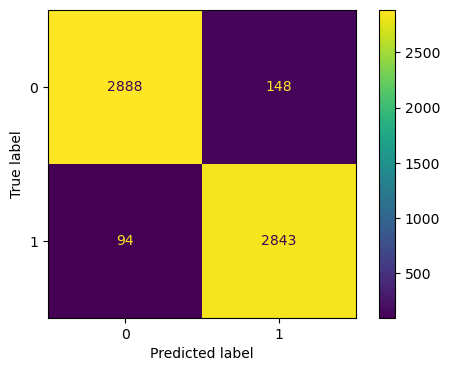

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      3036
           1       0.95      0.97      0.96      2937

    accuracy                           0.96      5973
   macro avg       0.96      0.96      0.96      5973
weighted avg       0.96      0.96      0.96      5973



In [34]:
#predict y values from X_test set
y_pred = grid_search.predict(X_test)

#print the best parameters from the grid search
print(grid_search.best_estimator_)

#determine accuracy of model using actual y_test values and predicted y_pred values
print('Model 5 accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

#display confustion matrix for base model of XGBoost
display_confusion_matrix(y_test, y_pred, grid_search)

#classification report
class_report(y_test, y_pred)

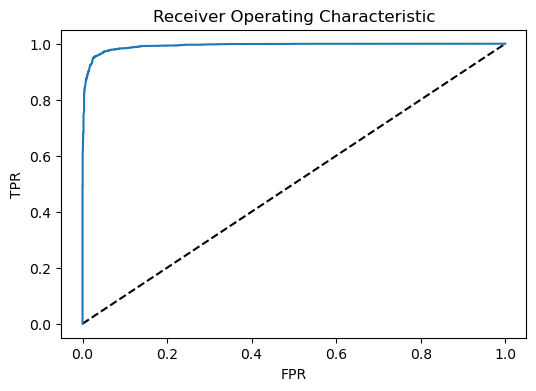

In [35]:
#ROC curve for XGBoost with grid search for OVERsampling data
y_pred_prob1 = grid_search.predict_proba(X_test)[:,1]
fpr1 , tpr1, thresholds1 = roc_curve(y_test, y_pred_prob1)

plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label= "Model 5")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('Receiver Operating Characteristic')
plt.show()

# Model 6 -Grid Search for XGBoost for Undersampling Data

In [36]:
#fit the grid search on the X_train and y_train data of the UNDERsampling data
grid_search.fit(X_train_under, y_train_under)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None, ...),
             n_jobs=10,
             param_grid={'colsample_bytree': [0.2, 0.5],
                         'learning_rate': [0.2, 0.4, 0.6],
                         'max_depth': range(2, 10, 2),
                         'min_child_weight': range(2, 7),
                         'n_estimators': range(120, 220, 40)},
             scoring='roc_auc', verbose=True)

In [37]:
#predict y values from X_test set
y_pred_under = grid_search.predict(X_test_under)

#print the best parameters from the grid search
print(grid_search.best_estimator_)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, nthread=4, num_parallel_tree=None,
              predictor=None, ...)


Model 6 accuracy score: 0.8127


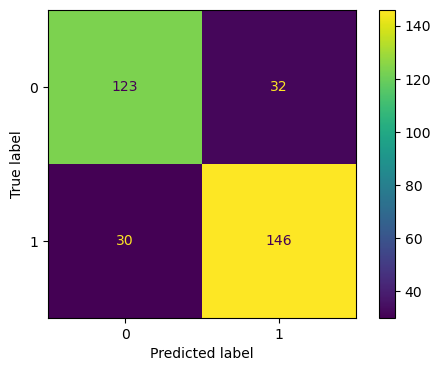

              precision    recall  f1-score   support

           0       0.80      0.79      0.80       155
           1       0.82      0.83      0.82       176

    accuracy                           0.81       331
   macro avg       0.81      0.81      0.81       331
weighted avg       0.81      0.81      0.81       331



In [38]:
#determine accuracy of model using actual y_test values and predicted y_pred values
print('Model 6 accuracy score: {0:0.4f}'. format(accuracy_score(y_test_under, y_pred_under)))

#display confustion matrix for base model of XGBoost
display_confusion_matrix(y_test_under, y_pred_under, grid_search)

#classification report
class_report(y_test_under, y_pred_under)

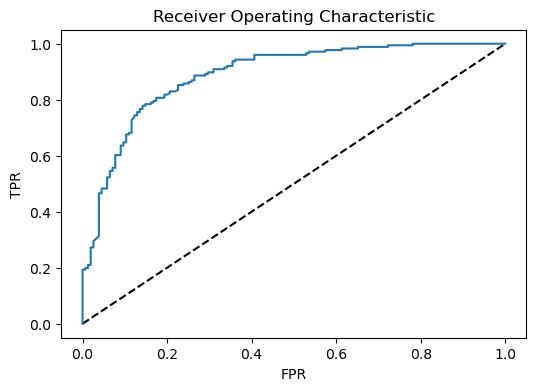

In [39]:
#ROC curve for XGBoost with grid search for UNDERsampling data
y_pred_prob1 = grid_search.predict_proba(X_test_under)[:,1]
fpr1 , tpr1, thresholds1 = roc_curve(y_test_under, y_pred_prob1)

plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label= "Model 6")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('Receiver Operating Characteristic')
plt.show()

## Model 7: XGBoost for Oversampling Data with Hyperopt 

In [40]:
#create the objective function
def objective(space):
    classifier = xgb.XGBClassifier(n_estimators = space['n_estimators'],
                            max_depth = int(space['max_depth']),
                            learning_rate = space['learning_rate'],
                            gamma = space['gamma'],
                            min_child_weight = space['min_child_weight'],
                            subsample = space['subsample'],
                            colsample_bytree = space['colsample_bytree']
                            )
    
    classifier.fit(X_train, y_train)

    # Applying k-Fold Cross Validation
    from sklearn.model_selection import cross_val_score
    accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
    CrossValMean = accuracies.mean()

    print("CrossValMean:", CrossValMean)

    return{'loss':1-CrossValMean, 'status': STATUS_OK }
#define the space 
space = {
    'max_depth' : hp.choice('max_depth', range(1, 14, 1)),
    'learning_rate' : hp.quniform('learning_rate', 0.01, 0.9, 0.04),
    'n_estimators' : hp.choice('n_estimators', range(20, 205, 10)),
    'gamma' : hp.quniform('gamma', 0, 0.40, 0.01),
    'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 2),
    'subsample' : hp.quniform('subsample', 0.01, 1, 0.1),
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1.0, 0.1)}


#determine best model using the fmin function
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

print("Best: ", best)

CrossValMean:                                                                   
0.940591459037347                                                               
CrossValMean:                                                                   
0.9420262307643981                                                              
CrossValMean:                                                                   
0.8539153030988104                                                              
CrossValMean:                                                                   
0.9344920956493885                                                              
CrossValMean:                                                                   
0.929972314946324                                                               
CrossValMean:                                                                   
0.8836927515214933                                                              
CrossValMean:               

In [41]:
# Using the best parameters found from the hyperopt model 
model_7 = XGBClassifier(n_estimators = best['n_estimators'],
                            max_depth = best['max_depth'],
                            learning_rate = best['learning_rate'],
                            gamma = best['gamma'],
                            min_child_weight = best['min_child_weight'],
                            subsample = best['subsample'],
                            colsample_bytree = best['colsample_bytree']
                            )
#fitting the model on the training data
model_7.fit(X_train, y_train)

# Applying k-Fold Cross Validation
accuracies = cross_val_score(estimator = model_7, X = X_train, y = y_train, cv = 10)
CrossValMean = accuracies.mean()
print("Final CrossValMean: ", CrossValMean)

Final CrossValMean:  0.9161244323688539


Model 7 accuracy score: 0.9257


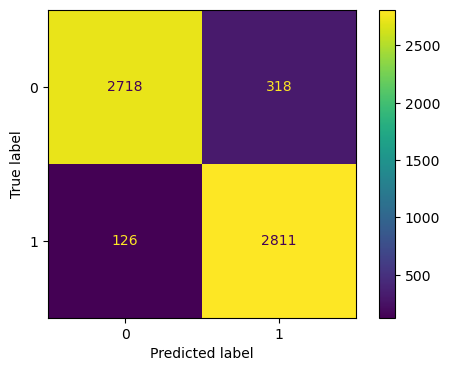

              precision    recall  f1-score   support

           0       0.96      0.90      0.92      3036
           1       0.90      0.96      0.93      2937

    accuracy                           0.93      5973
   macro avg       0.93      0.93      0.93      5973
weighted avg       0.93      0.93      0.93      5973



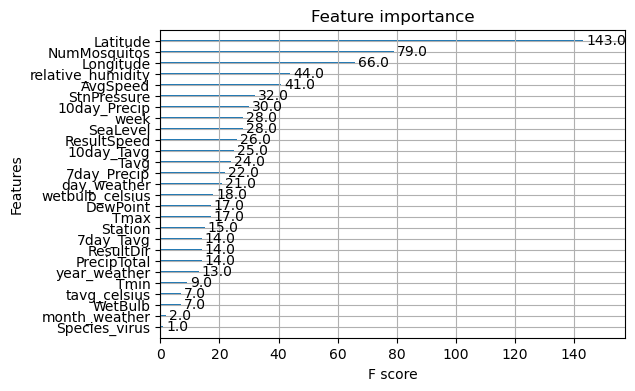

In [42]:
#predict y values from X_test set
y_pred = model_7.predict(X_test)

#determine accuracy of model using actual y_test values and predicted y_pred values
print('Model 7 accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

#display confustion matrix for base model of XGBoost
display_confusion_matrix(y_test, y_pred, model_7)

#classification report
class_report(y_test, y_pred)

#feature importance
feature_importance(model_7)

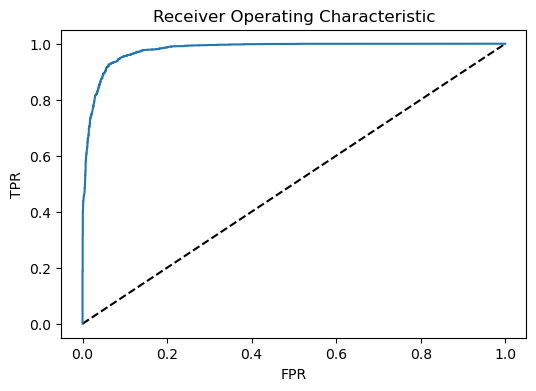

In [43]:
#ROC curve for XGBoost with grid search for OVERsampling data
y_pred_prob1 = model_7.predict_proba(X_test)[:,1]
fpr1 , tpr1, thresholds1 = roc_curve(y_test, y_pred_prob1)

plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label= "Model 7")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('Receiver Operating Characteristic')
plt.show()

Top left quadrant = True Positives = Number of mosquitoes NOT carrying West Nile virus
Bottom right quadrant = True Negatives = Number of mosquitoes carrying West Nile virus
Top right quadrant = False Positives = Number of mosquitoes that are not carrying virus labeled as carrying virus 
Bottom left quadrant = False Negatives = Number of mosquitoes carrying virus labeled as NOT carrying virus 

## Model 8 - Random Forest for Oversampling Data

This is the base model for random forest.

In [44]:
model_8 = RandomForestClassifier(n_estimators = 100)   
  
# Train the model
model_8.fit(X_train, y_train) 
  
# Make y predictions on the X_test data
y_pred = model_8.predict(X_test) 
  
# using metrics module for accuracy calculation 
print('Model 8 accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model 8 accuracy score: 0.9496


## Model 9 - Random Forest with Grid Search for Oversampling Data

In [45]:
#use Grid search on Random Forest model
param_grid = { 
    'n_estimators': [50, 100, 150, 200], 
    'max_features': ['sqrt', 'log2', None], 
    'max_depth': [4, 8, 12], 
    'max_leaf_nodes': [4, 8, 12], 
} 

In [46]:
#train model on different parameters using grid search to find a better model
model_9 = GridSearchCV(RandomForestClassifier(), 
                           param_grid=param_grid) 
model_9.fit(X_train, y_train) 
print(model_9.best_estimator_) 

RandomForestClassifier(max_depth=8, max_leaf_nodes=12, n_estimators=200)


In [47]:
#use best parameters from GridSearch above
model_9_best = RandomForestClassifier(max_depth=12,
                                    max_features=None, 
                                    max_leaf_nodes=12, 
                                    n_estimators=150) 
model_9_best.fit(X_train, y_train) 

RandomForestClassifier(max_depth=12, max_features=None, max_leaf_nodes=12,
                       n_estimators=150)

Model 9 accuracy score : 0.8204


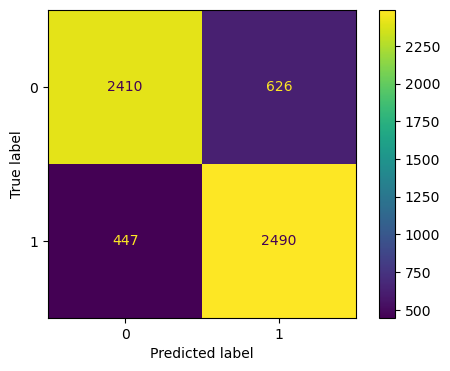

              precision    recall  f1-score   support

           0       0.84      0.79      0.82      3036
           1       0.80      0.85      0.82      2937

    accuracy                           0.82      5973
   macro avg       0.82      0.82      0.82      5973
weighted avg       0.82      0.82      0.82      5973



In [48]:
#predict y values from X_test set
y_pred = model_9_best.predict(X_test)

#determine accuracy of model using actual y_test values and predicted y_pred values
print('Model 9 accuracy score : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

#display confustion matrix for base model of XGBoost
display_confusion_matrix(y_test, y_pred, model_9_best)

#classification report
class_report(y_test, y_pred)

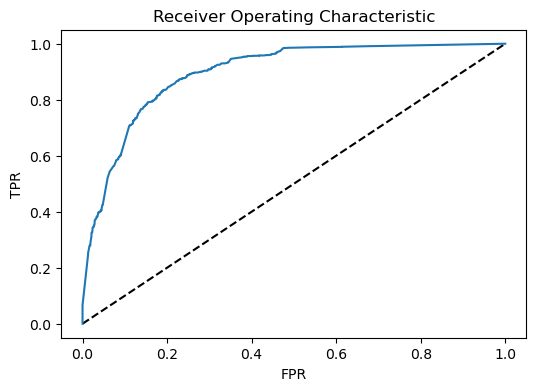

In [49]:
#ROC curve for Random Forest
y_pred_prob1 = model_9_best.predict_proba(X_test)[:,1]
fpr1 , tpr1, thresholds1 = roc_curve(y_test, y_pred_prob1)

plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label= "Random Forest")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('Receiver Operating Characteristic')
plt.show()

## Model 10 - Base Model for Random Forest for Undersampling Data

In [50]:
model_10 = RandomForestClassifier(n_estimators = 100)   
  
# Train the model
model_10.fit(X_train_under, y_train_under) 
  
# Make y predictions on the X_test data
y_pred_under = model_10.predict(X_test_under) 
  
# using metrics module for accuracy calculation 
print("Model 10 accuracy score {0:0.4f} : ", accuracy_score(y_test_under, y_pred_under)) 

Model 10 accuracy score {0:0.4f} :  0.7824773413897281


## Model 11- Grid Search for Random Forest for Undersampling Data

In [51]:
#using param_grid from above from Undersampling random forest

#train model on different parameters using grid search to find a better model
model_11 = GridSearchCV(RandomForestClassifier(), 
                           param_grid=param_grid) 
model_11.fit(X_train_under, y_train_under) 
print(model_11.best_estimator_)

RandomForestClassifier(max_depth=12, max_leaf_nodes=12, n_estimators=200)


In [52]:
#use best parameters from GridSearch above
model_11_best = RandomForestClassifier(max_depth=8,
                                    max_features='log2', 
                                    max_leaf_nodes=12, 
                                    n_estimators=50) 
model_11_best.fit(X_train_under, y_train_under) 

RandomForestClassifier(max_depth=8, max_features='log2', max_leaf_nodes=12,
                       n_estimators=50)

Model 11 accuracy score: 0.8369


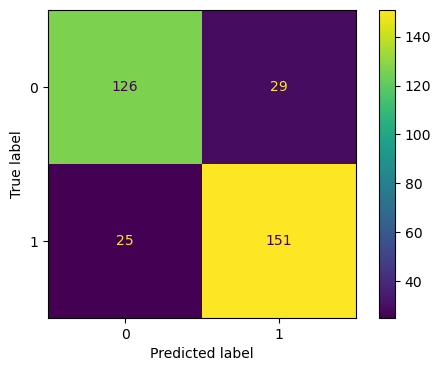

              precision    recall  f1-score   support

           0       0.83      0.81      0.82       155
           1       0.84      0.86      0.85       176

    accuracy                           0.84       331
   macro avg       0.84      0.84      0.84       331
weighted avg       0.84      0.84      0.84       331



In [53]:
#predict y values from X_test set
y_pred_under = model_11_best.predict(X_test_under)

#determine accuracy of model using actual y_test values and predicted y_pred values
print('Model 11 accuracy score: {0:0.4f}'. format(accuracy_score(y_test_under, y_pred_under)))

#display confustion matrix for base model of XGBoost
display_confusion_matrix(y_test_under, y_pred_under, model_11_best)

#classification report
class_report(y_test_under, y_pred_under)

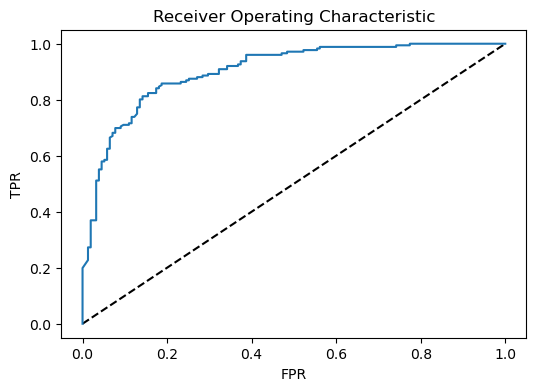

In [54]:
#ROC curve for Random Forest
y_pred_prob1_under = model_11_best.predict_proba(X_test_under)[:,1]
fpr1 , tpr1, thresholds1 = roc_curve(y_test_under, y_pred_prob1_under)

plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label= "Random Forest for Undersampling")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('Receiver Operating Characteristic')
plt.show()